In [3]:
import pandas as pd
import numpy as np
import seaborn as sb

### Baseline

In [3]:
sample = pd.read_csv('data/sample_submission.csv')

In [22]:
baseline = pd.DataFrame(0.066, index=np.arange(len(sample)), columns=sample.columns)
baseline['object_id'] = sample['object_id']

In [26]:
baseline.to_csv('baseline_submission.csv.gz', compression='gzip', index=False)

### Data exploration

In [4]:
!ls data

baseline_submission.csv   sample_submission.csv.zip test_set_sample.csv
data_note.pdf             test_set.csv              test_set_sample.csv.zip
data_note.pdf.zip         test_set.csv.zip          training_set.csv.zip
sample_submission.csv     test_set_metadata.csv.zip training_set_metadata.csv


In [2]:
metadata = pd.read_csv('data/training_set_metadata.csv')
train_set = pd.read_csv('data/training_set.csv')

FileNotFoundError: File b'data/training_set_metadata.csv' does not exist

In [11]:
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


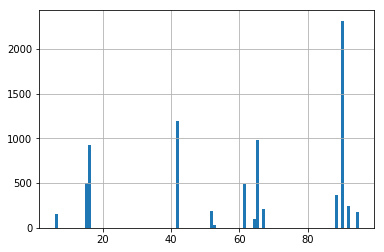

In [10]:
metadata['target'].hist(bins=100)

In [6]:
train_set.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


README.md           data                plasticc-2018.ipynb
